# Credit Card Fraud Detection

# Step 1: Install Required Packages

In [1]:
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", 
                       "lightgbm", "imbalanced-learn", "seaborn", "matplotlib"])
print("Packages installed successfully!\n")

Packages installed successfully!



# Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, precision_recall_curve, auc
)
import lightgbm as lgb
from imblearn.combine import SMOTETomek

sns.set(style="whitegrid")
print("Libraries imported successfully!\n")

Libraries imported successfully!



# Step 3: Load Dataset

In [3]:
print("Loading datasets...")
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}\n")

Loading datasets...
Train Data Shape: (1296675, 23)
Test Data Shape: (555719, 23)



# Step 4: Data Exploration

Exploring target variable distribution...


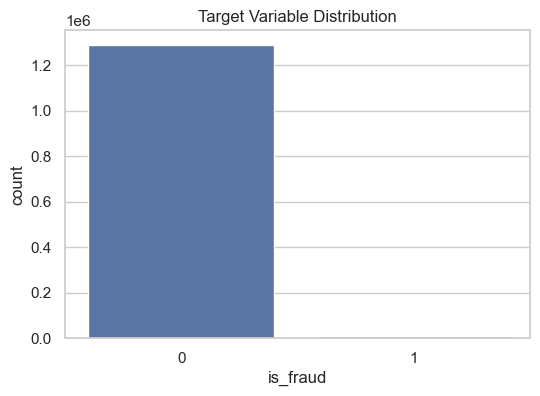

Target counts:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64 

Using 10 numeric features: ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']



In [4]:
print("Exploring target variable distribution...")
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=train_data)
plt.title("Target Variable Distribution")
plt.show()

print("Target counts:")
print(train_data['is_fraud'].value_counts(), "\n")

numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('is_fraud')
print(f"Using {len(numeric_cols)} numeric features: {numeric_cols}\n")

# Step 5: Prepare Data

In [5]:
print("Preparing and scaling data...")
X_train = train_data[numeric_cols].fillna(0)
y_train = train_data['is_fraud']

X_test = test_data[numeric_cols].fillna(0)
y_test = test_data['is_fraud']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data scaling completed!\n")

Preparing and scaling data...
Data scaling completed!



# Step 6: Handle Class Imbalance

In [6]:
print("Balancing dataset using SMOTE + Tomek...")
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train_scaled, y_train)
print("Resampling completed!")
print("Class distribution after resampling:")
print(pd.Series(y_res).value_counts(), "\n")

Balancing dataset using SMOTE + Tomek...
Resampling completed!
Class distribution after resampling:
is_fraud
0    1289097
1    1289097
Name: count, dtype: int64 



# Step 7: Train LightGBM Model

In [7]:
print("Training LightGBM model...")
fraud_ratio = y_res.value_counts()[0] / y_res.value_counts()[1]

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=31,
    class_weight={0:1, 1:fraud_ratio},
    random_state=42
)

lgb_model.fit(X_res, y_res)
print("Model training completed!\n")

Training LightGBM model...
[LightGBM] [Info] Number of positive: 1289097, number of negative: 1289097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2578194, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model training completed!



# Step 8: Predictions & Threshold Tuning

In [8]:
print("Making predictions and tuning threshold for best F1-score...")
y_prob = lgb_model.predict_proba(X_test_scaled)[:,1]

thresholds = np.arange(0.01, 0.5, 0.01)
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold selected: {best_thresh:.2f}")

y_pred = (y_prob >= best_thresh).astype(int)
print("Predictions completed!\n")

Making predictions and tuning threshold for best F1-score...
Best threshold selected: 0.49
Predictions completed!



# Step 9: Evaluate Model

In [9]:
print("Evaluating model performance...")
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)

print("LightGBM Performance Metrics (Threshold Tuned):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")

Evaluating model performance...
LightGBM Performance Metrics (Threshold Tuned):
Accuracy: 0.9905
Precision: 0.1591
Recall: 0.3436
F1-Score: 0.2175
ROC-AUC: 0.9031
PR-AUC: 0.1297



# Step 10: Visualizations

# 10.1 Confusion Matrix

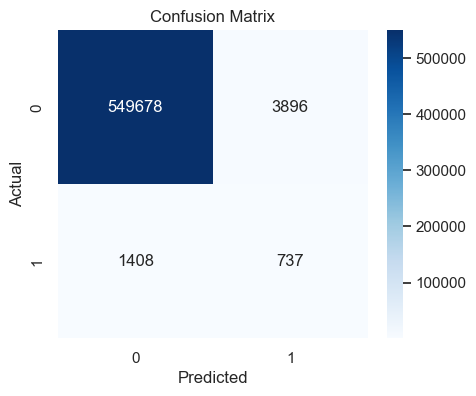

In [10]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10.2 ROC Curve

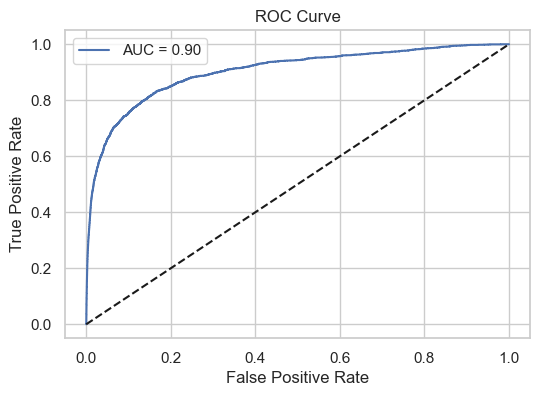

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 10.3 Precision-Recall Curve

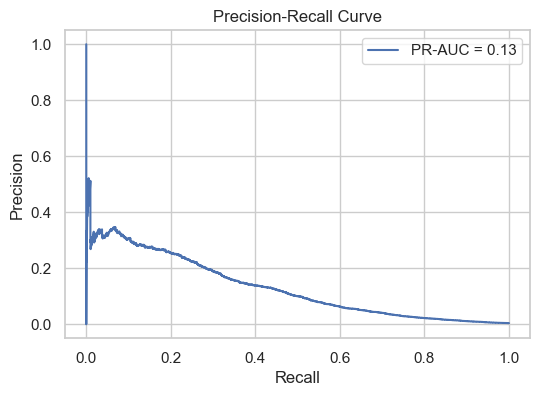

In [12]:
plt.figure(figsize=(6,4))
plt.plot(recall_curve, precision_curve, label=f"PR-AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 10.4 Feature Importance

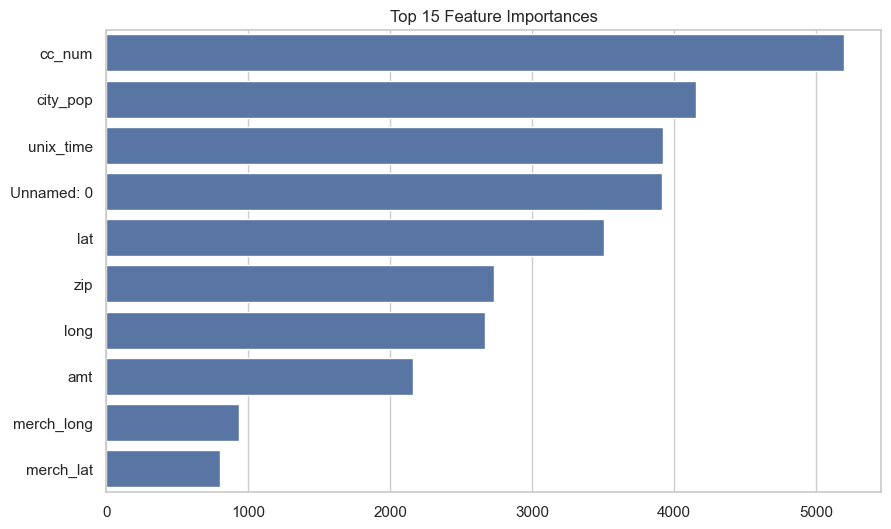

In [13]:
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:15], y=np.array(numeric_cols)[indices][:15])
plt.title("Top 15 Feature Importances")
plt.show()

# Step 11: Save Model

In [14]:
import pickle

artifacts = {
    'model': lgb_model,
    'scaler': scaler,
    'feature_columns': numeric_cols,
    'metrics': {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc_auc
    },
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

with open('model.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("Model saved as model.pkl!")

Model saved as model.pkl!
